# Review: Auto-Encoding Variational Bayes
**Diederik P.Kingma et al., 2014.**

### Why manifold learning?
- Generative model을 학습한다는 것 = Plausible output을 잘 내는것?
- Generative model은 $p(x)$ 자체를 학습
- Arbitrary gaussian noise에서 plausible output을 낼 확률은 극히 드물다.
- 이를테면 Image의 200X200 pixel 조합 중에서 plausible output은 일부에 불과한데, 이러한 조합들을 포괄하는 manifold가 존재한다는 manifold hypothesis <br/>
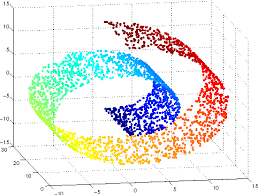</img> <br/>
- VAE는 manifold를 학습한 이후, 학습한 latent space에서의 sampling을 통해서 plausible output을 생성하는 것이 목표이다.

### Previous Challenges
- Posterior distributions of continuouslatent variables & parameters are intractable.
    - $p_\theta(x), p_\theta{(z|x)}$ 모두 intractable
- Efficient approximate posterior inference in directed probabilistic model is required.

### Contributions
- Derive a differentiable, unbiased estimator : lower bound estimator(ELBO) that can be used in optimizing stochastic gradient methods.
- Efficient posterior inference by fitting an approximate inference model, especially powerful in large datasets.
-  ```Core of VAE``` : Variational inference를 활용해 distribution의 학습 문제를 paramter optimization으로 바꾸고, posterior $q(z|x)$와 likelihood $p(x|z)$를 encoder와 decoder로 바꾸어 Neural Network를 모델링한 다음 Gradient Descent를 활용해 update하자.

### Problem Statement
- Efficient approximate ML or MAP estimation, for the parameters $\theta$.
- Efficient approximate posterior inference of the latent variable $z$ when observed value $x$ is given for a choice of parameters $\theta$.
- Efficient approximate marginal inference of the variable $x$(이것을 아는 것이 사실 최종 목표).

### Method
#### 01. Problem scenario
- samples $X$ consisting N i.i.d continuous or discreate variable $x$
- $X$ is sampled from unobserved continous random variable $z$
    - assume prior distribution of $z$ as $p_\theta^*(z)$, value $x^{(i)}$ generated from conditional distribution $p_\theta^*(x|z)$
    - true parameter $\theta^*$ and latent variables $z^{(i)}$ are hidden
    - we only know the output $x$ when paramter $\theta$ is chosen for generation.
- introduce recognition model $q_\phi{(z|x)}$ for approximation of true intractable posterior $p_\theta(z|x)$.
> Remark: Is this idea novel one? Mean-field variational inference
> - Variational Bayesian 관점에서 Mean-field approximation이 이미 제시된 바 있음
> - Approximate $p(\theta|x)$ with $g(\theta|\phi)$
> - Assume $g(\theta|\phi)$ is separable : $g(\theta|\phi) = \prod_{j=1}^{J} g_j(\theta_j|\phi_j)$, and $\phi^* = arg \min_\phi KL(g(\theta|\phi)||p(\theta|x))$
> - Not all distributions are seperable in parameters.

- inspiration of VAE architecture <br/>
    <img src = "https://user-images.githubusercontent.com/75057952/158972925-e275505a-602e-4383-afc0-22204b0ee1c0.png" width = "600dp"></img>

#### 02. Variational bound derivation
- $\log p_\theta(X) = \log p_\theta(x^{(1)}, ..., x^{(N)}) = \sum_{i=1}^N \log p_\theta(x^{(i)})$

**Proof 1 : Based on paper** <br/>
- $\log p(x) = \log p(x) \int q(z|x)dz = \int q(z|x) \log p(x) dz$
- **By bayes theorem**, $\int q(z|x) \log p(x) dz = \int q(z|x) \log{p(x|z)p(z) \over p(z|x)}dz \\ = \int q(z|x) {[\log p(x|z) + \log p(z) - \log p(z|x)]} dz \\ =  \int q(z|x) \log p(x|z) + \int q(z|x) \log p(z) dz - \int q(z|x) \log p(z|x_i) dz \pm \int q(z|x) \log q(z|x) dz \\ = \mathbb{E}_{q(z|x)}[\log p(x|z)] + {[\int q(z|x) \log p(z) dz - \int q(z|x) \log q(z|x) dz]} + {[\int q(z|x) \log q(z|x) dz-\int q(z|x) \log p(z|x) dz]} \\ = \mathbb{E}_{q(z|x)}[\log p(x|z)] + KL(q(z|x)||p(z|x)) \text{ (intractable) } - KL(q(x|z)||p(z) \text{ (tractable if we suppose gaussian dist.) } \\ \geq \mathbb{E}_{q(z|x)}[\log p(x|z)] - KL(q(x|z)||p(z)) = \mathcal L\text{ (i.e. ELBO)}$

**Proof 2 : Shortcut with jensen inequality** <br/>
- $\log p(x) = \log(\int{{p(x,z) \over q_\phi(z|x)}q_\phi(z|x)dz) = \log (\mathbb E_{q_\phi(z|x)}[{p(x,z) \over q_\phi(z|x)}])\geq \mathbb E_{q_\phi(z|x)}{[\log {p(x,z) \over q_\phi(z|x)}]}}: \text{by Jensen Inequality}$
- $\mathbb E_{q_\phi(z|x)}{[\log {p(x,z) \over q_\phi(z|x)}]}  = \mathbb E_{q_\phi(z|x)}{[\log {p(x|z)p(z) \over q_\phi(z|x)}]}\\  = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - E_{q_\phi(z|x)}{[{q_\phi(z|x) \over p(z)}]} \\ = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - \int {q_\phi(z|x) \over p(z)}q_\phi(z|x) dz \\ = E_{q_\phi(z|x)}{[\log {p(x|z)}]} - KL(q_\phi(z|x)||p(z)) = \mathcal L\text{ (i.e. ELBO)}$

**Thus,**
<img src = "https://user-images.githubusercontent.com/75057952/158972941-2451f4a4-d182-4782-baa9-2e02e59e5f65.png" width = "600dp"></img>
- Expectation value의 gradient 자체를 Monte Carlo estimation으로 추정하여 update에 활용할 때는 sampled gradient value의 variance가 매우 높다는 문제가 있음.
- Expectation value를 reparametrizing trick을 통해 변환하고, Monte Carlo expectation value 자체를 estimate하여 neural network에서의 gradient descent를 통해 paramter update가 가능함.

### 03. SGVB estimator,  AEVB algorithm and reparamterization trick

- 위의 식에서 ELBO Term을 구했고, ELBO를 object function으로 두고 parmeter update가 필요함. 이때 Gradient을 어떻게 계산할까?
- 우선 Stochastic Sampling을 통하게 되는 순간 expectation value가 q에 dependent하던 조건이 사라지는 문제가 발생함.
- 그리고 Expectation value의 gradient 자체를 Monte Carlo estimation으로 추정하여 update에 활용할 때는 sampled gradient value의 variance가 매우 높다는 문제가 있음.
- Expectation value를 reparametrizing trick을 통해 변환하면 z가 아닌 $\epsilon$에 stochasticy가 더해지고, z는 q로부터 직접 sampling됨.
- 그리고 Monte Carlo expectation value 자체를 estimate하여 neural network에서의 gradient descent를 통해 paramter update가 가능 :  ```contribution of SGVB estimator```
- random variable $z$를 $x$와 error(auxiliary) noise variable $\epsilon$에 의존적인 term으로 가정(여기서는 *Gaussian Dist.*) <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158972850-9d8dd10b-3cd4-4ed6-9c4d-c66c241d9466.png" width = "700dp"></img>

- AEVB algorithm <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158973022-4d3e95b0-ad7a-4bb6-b279-640fd8eb7137.png" width = "500dp"></img>

### 04. Example : Univariate gaussian-distribution case
### Remark : $q(z|x) \text{ as encoder }, p(x|z) \text{ as decoder} $
**Encoder**
- suppose $z ∼ p(z|x) = N (\mu, \sigma^2)$ : Gaussian Encoder
- valid reparameterization : $z = \mu + \sigma\epsilon$, where $\epsilon$ is an auxiliary noise variable $\epsilon ∼ N (0, 1)$. 
- Therefore, $\mathbb E_{N(z;\mu,\sigma^2)} [f(z)] = \mathbb E_{N(\epsilon;0,1)}[f(\mu + \sigma\epsilon)] \sim {1 \over L} \sum_{i=1}^L f(\mu + \sigma\epsilon^{(l)}) \text{ where } \epsilon^{(l)} \sim N(0,1)$
- ELBO is calculated as... (KL term can be explicitly calculated if gaussian, thus we can apply estimator B !!!) <br/>
<img src = "https://user-images.githubusercontent.com/75057952/158973037-53fc9efc-fb6d-4c6f-8064-bb617a3d8248.png" width = "380dp"></img>
<img src = "https://user-images.githubusercontent.com/75057952/158973047-a1e92cfb-3eb9-4dfd-8428-778977770e30.png" width = "500dp"></img>

**Decoder** : Bernoulli MLP and Gaussian MLP
- 인코더의 역할이 latent space로의 임베딩을 '잘' 만드는 것이라면, 디코더의 역할은 latent space에서 sampling된 z로부터 생성된 output이 실제 p(x)를 반영하여 잘 만들어지기를 목표로 함.

# Implementation: [Reference](https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb)

## Import packages

In [1]:
!nvidia-smi

Fri Mar 18 12:57:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## Model.py

In [3]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        #Encoder with MLP
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        #Decoder with MLP
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var) # log variance를 학습하는 이유는 scale 때문인 것 같습니다
        eps = torch.randn_like(std) # std와 같은 dimension의 random noise
        return eps.mul(std).add_(mu) # return z sample
        # pytorch에서 메소드 뒤에 _를 붙이는 게 inplace 연산이라고 합니다.

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h))
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784)) #28X28 image to 784-dim 1D tensor
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
        
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [4]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

## Loss.py

In [5]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
# Reconstruction error는 cross-entropy로 계산합니다.
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

## Train&Eval.py

In [8]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader)))

In [9]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Run.py

In [10]:
for epoch in range(1, 51):
    train(epoch)
    test()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.642617
Train Epoch: 1 [10000/60000 (17%)]	Loss: 188.930254
Train Epoch: 1 [20000/60000 (33%)]	Loss: 163.929785
Train Epoch: 1 [30000/60000 (50%)]	Loss: 166.007676
Train Epoch: 1 [40000/60000 (67%)]	Loss: 162.579609
Train Epoch: 1 [50000/60000 (83%)]	Loss: 170.873437
====> Epoch: 1 Average loss: 17814.8189
====> Test set loss: 161.3266
Train Epoch: 2 [0/60000 (0%)]	Loss: 163.595186
Train Epoch: 2 [10000/60000 (17%)]	Loss: 167.064766
Train Epoch: 2 [20000/60000 (33%)]	Loss: 153.911484
Train Epoch: 2 [30000/60000 (50%)]	Loss: 167.815039
Train Epoch: 2 [40000/60000 (67%)]	Loss: 161.172588
Train Epoch: 2 [50000/60000 (83%)]	Loss: 161.164199
====> Epoch: 2 Average loss: 15739.5295
====> Test set loss: 154.5096
Train Epoch: 3 [0/60000 (0%)]	Loss: 159.336973
Train Epoch: 3 [10000/60000 (17%)]	Loss: 149.002070
Train Epoch: 3 [20000/60000 (33%)]	Loss: 151.389521
Train Epoch: 3 [30000/60000 (50%)]	Loss: 156.066406
Train Epoch: 3 [40000/60000 (67%)]	Loss: 15

In [16]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae.decoder(z).cuda()
    image = sample.view(64,1,28,28).detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


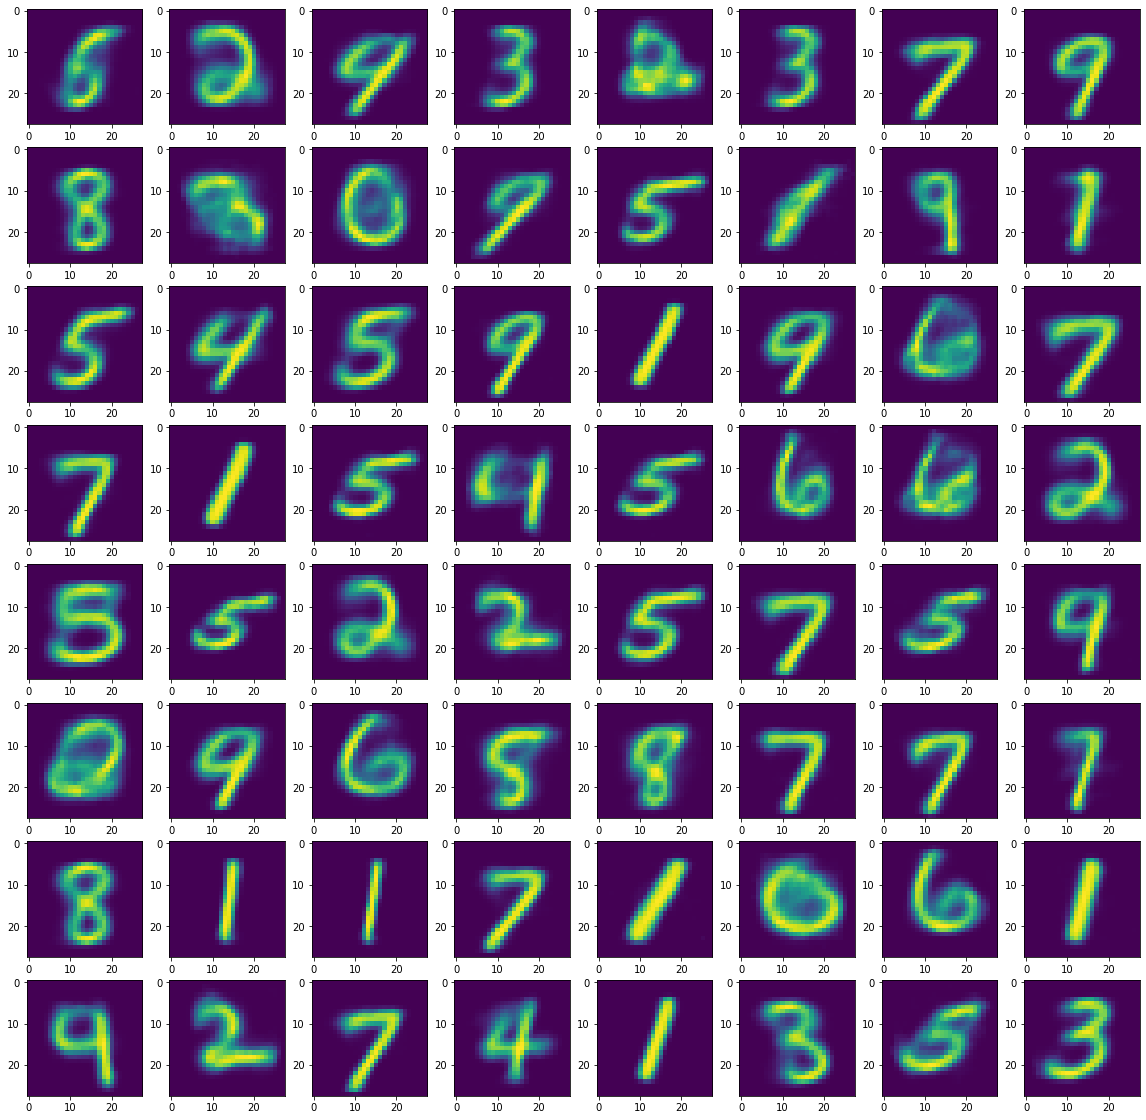

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(8,8, figsize = (20,20))
for i in range(len(image)):
    ax[i//8][i%8].imshow(*image[i])